In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
df = pd.read_csv('/Users/erenanbar/Desktop/data/ticketData_vs_disconnections.csv')
df.head(3)
    

,day,modelName,numDisconnection,maxDuration,ticket_size,total_size
0,2023-02-23,DLink DIR-853/ET,4,20.0,0,1
1,2023-02-23,DLink DIR-853/ET,15,145.0,0,1
2,2023-02-23,DLink DIR-853/ET,5,250.0,0,1


Text(0.5, 0, 'max duration binned ')

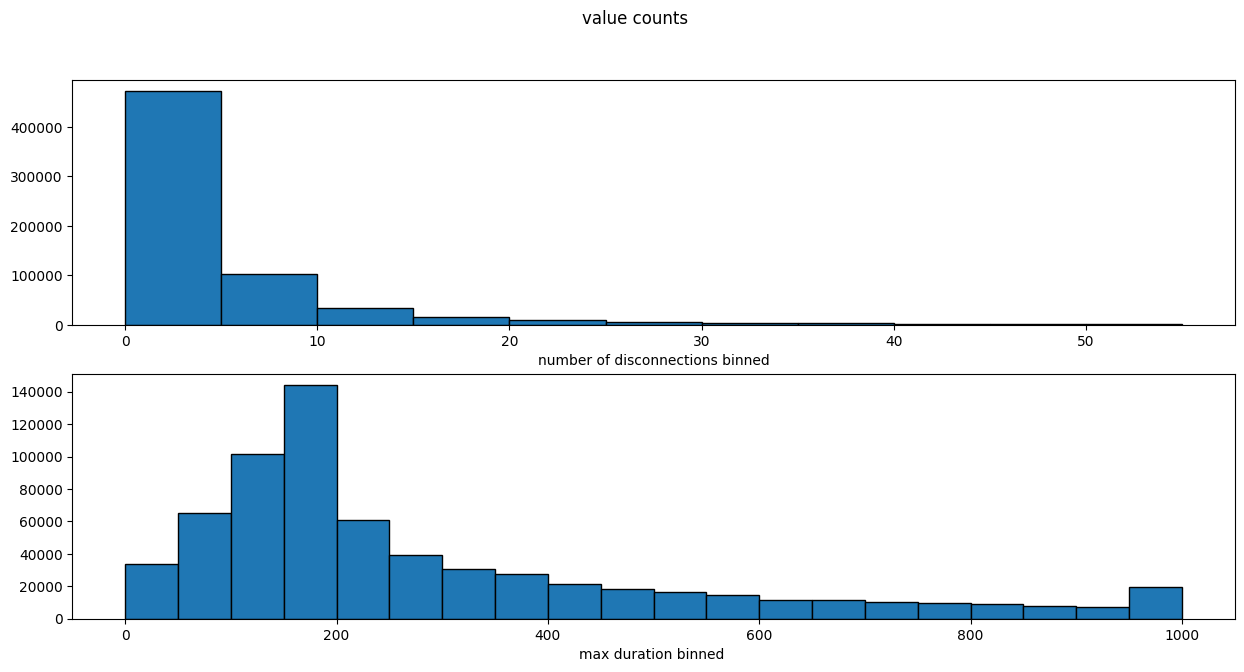

In [2]:
#disconnection bins
bins_disconnection = np.arange(start = 0, stop = df['numDisconnection'].quantile(0.99), step = 5)
#bins = np.append(bins,np.max(df['numDisconnection'])) if the quantile > 0.99 is included in the bins model is not behaving as expected
df['disconnection_bin'] = pd.cut(df['numDisconnection'], 
                        bins=bins_disconnection,
                        labels = range(1,len(bins_disconnection)))
#max duration bins
bins_max_duration = np.arange(start = 0, stop = np.max(df['maxDuration'])+1, step = 50)
df['max_duration_bin'] = pd.cut(df['maxDuration'], 
                            bins = bins_max_duration,
                            labels = range(1,len(bins_max_duration)))

fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(15, 7)  
fig.suptitle('value counts')
ax1.hist(df['numDisconnection'], bins=bins_disconnection, edgecolor = 'black')
ax1.set_xlabel('number of disconnections binned')
ax2.hist(df['maxDuration'], bins=bins_max_duration, edgecolor = 'black')
ax2.set_xlabel('max duration binned ')

Text(0, 0.5, 'call_prob')

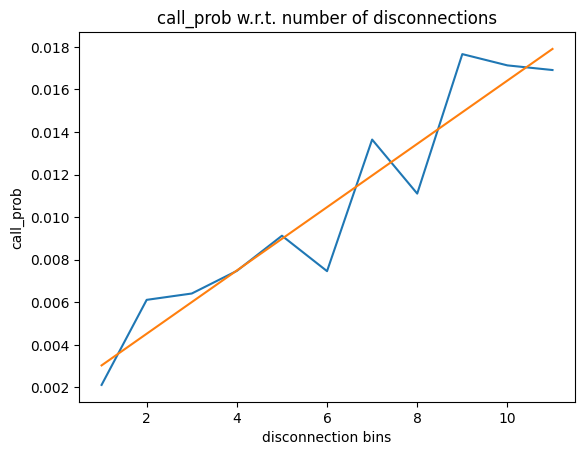

In [3]:
# calculate prob w.r.t. disconnection only
df_grouped = df.groupby(['modelName','disconnection_bin']).aggregate({'ticket_size':'sum','total_size':'sum'})
df_grouped['call_prob'] = df_grouped['ticket_size'] / df_grouped['total_size']
df_grouped = df_grouped.reset_index()

for model in df_grouped['modelName'].unique():
    X = df_grouped.loc[df_grouped['modelName'] == model, ['disconnection_bin']]
    y = df_grouped.loc[df_grouped['modelName'] == model, 'call_prob'].fillna(0) 
    regr = LinearRegression()
    regr.fit(X, y)
    df_grouped.loc[df_grouped['modelName'] == model, 'prob_predict'] = regr.predict(X)
    
plt.plot(df_grouped.loc[df_grouped['modelName'] == 'DLink DIR-853/ET', 'disconnection_bin'], 
         df_grouped.loc[df_grouped['modelName'] == 'DLink DIR-853/ET', 'call_prob'])
plt.plot(df_grouped.loc[df_grouped['modelName'] == 'DLink DIR-853/ET', 'disconnection_bin'], 
         df_grouped.loc[df_grouped['modelName'] == 'DLink DIR-853/ET', 'prob_predict'])
plt.xlabel('disconnection bins')
plt.title('call_prob w.r.t. number of disconnections')
plt.ylabel('call_prob')

Text(0, 0.5, 'call_prob')

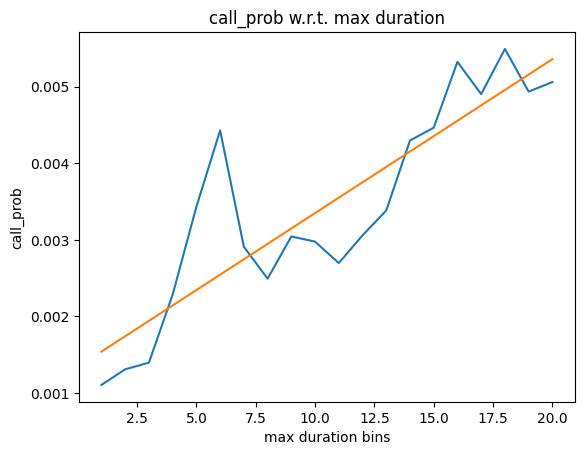

In [4]:
# calculate prob w.r.t. max duration only
df_grouped = df.groupby(['modelName','max_duration_bin']).aggregate({'ticket_size':'sum','total_size':'sum'})
df_grouped['call_prob'] = df_grouped['ticket_size'] / df_grouped['total_size']
df_grouped = df_grouped.reset_index()

for model in df_grouped['modelName'].unique():
    X = df_grouped.loc[df_grouped['modelName'] == model, ['max_duration_bin']]
    y = df_grouped.loc[df_grouped['modelName'] == model, 'call_prob'].fillna(0) 
    regr = LinearRegression()
    regr.fit(X, y)
    df_grouped.loc[df_grouped['modelName'] == model, 'prob_predict'] = regr.predict(X)
    
plt.plot(df_grouped.loc[df_grouped['modelName'] == 'DLink DIR-853/ET', 'max_duration_bin'], 
         df_grouped.loc[df_grouped['modelName'] == 'DLink DIR-853/ET', 'call_prob'])
plt.plot(df_grouped.loc[df_grouped['modelName'] == 'DLink DIR-853/ET', 'max_duration_bin'], 
         df_grouped.loc[df_grouped['modelName'] == 'DLink DIR-853/ET', 'prob_predict'])
plt.xlabel('max duration bins')
plt.title('call_prob w.r.t. max duration')
plt.ylabel('call_prob')

In [5]:
# calculate prob w.r.t. disconnection & max duration
df_grouped = df.groupby(['modelName','disconnection_bin','max_duration_bin']).aggregate({'ticket_size':'sum','total_size':'sum'})
df_grouped['call_prob'] = df_grouped['ticket_size'] / df_grouped['total_size']
df_grouped = df_grouped.reset_index()

for model in df_grouped['modelName'].unique():
    X = df_grouped.loc[df_grouped['modelName'] == model, ['disconnection_bin','max_duration_bin']]
    y = df_grouped.loc[df_grouped['modelName'] == model, 'call_prob'].fillna(0) 
    regr = LinearRegression()
    regr.fit(X, y)
    df_grouped.loc[df_grouped['modelName'] == model, 'prob_predict'] = regr.predict(X)
    

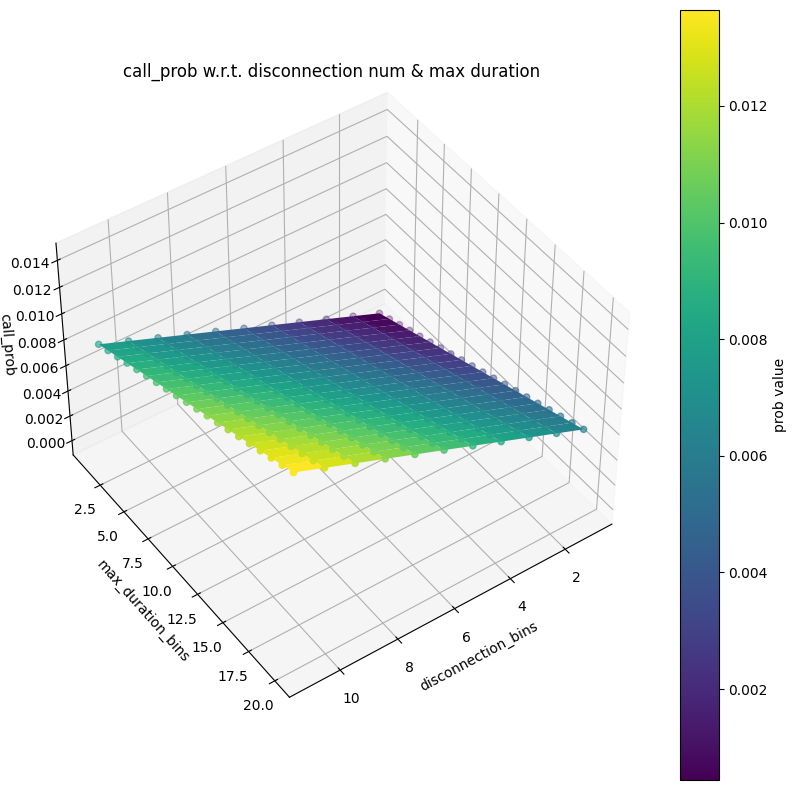

In [6]:
def f(x, y):
    mask = (df_grouped['modelName'] == 'DLink DIR-853/ET') & \
           (df_grouped['disconnection_bin'] == x) & \
           (df_grouped['max_duration_bin'] == y)
    return df_grouped.loc[mask, 'prob_predict'].iloc[0]
    #return df_grouped.loc[mask, 'call_prob'].iloc[0]
x = np.arange(1, df_grouped['disconnection_bin'].nunique()+1)
y = np.arange(1, df_grouped['max_duration_bin'].nunique()+1)
X, Y = np.meshgrid(x, y)
Z = np.vectorize(f)(X, Y)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='viridis') 
cbar = fig.colorbar(surface, ax=ax)
cbar.set_label('prob value')
scatter = ax.scatter(X, Y, Z, c=Z, cmap='viridis')  # Use Z values for color mapping
ax.set_title('call_prob w.r.t. disconnection num & max duration')
ax.set_xlabel('disconnection_bins')
ax.set_ylabel('max_duration_bins')
ax.set_zlabel('call_prob')
ax.view_init(elev=45, azim=55)
plt.show()

In [8]:
df_grouped

,modelName,disconnection_bin,max_duration_bin,ticket_size,total_size,call_prob,prob_predict
0,Arcadyan eLife Connect C1AA,1,1,5,100415,0.000050,0.000025
1,Arcadyan eLife Connect C1AA,1,2,7,37847,0.000185,0.000028
2,Arcadyan eLife Connect C1AA,1,3,5,42517,0.000118,0.000031
3,Arcadyan eLife Connect C1AA,1,4,2,39533,0.000051,0.000034
4,Arcadyan eLife Connect C1AA,1,5,1,14157,0.000071,0.000037
...,...,...,...,...,...,...,...
3295,etisalat_sercomm_s3_mtk_ccprpl,11,16,0,0,NaN,0.000000
3296,etisalat_sercomm_s3_mtk_ccprpl,11,17,0,0,NaN,0.000000
3297,etisalat_sercomm_s3_mtk_ccprpl,11,18,0,0,NaN,0.000000
3298,etisalat_sercomm_s3_mtk_ccprpl,11,19,0,0,NaN,0.000000
